In [52]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import altair as alt
from IPython.display import HTML

In [53]:
#!pip install fbprophet

In [54]:

from fbprophet import Prophet

# http://www-personal.umich.edu/~mejn/cp/data/sunspots.txt

data = np.loadtxt("sunspots.txt", float)


### Converting data to Pandas dataframe

In [55]:
# View the data as a table
data_as_frame = pd.DataFrame(data, columns=['Months', 'SunSpots'])
data_as_frame.tail(10)

,Months,SunSpots
3133,3133.0,18.8
3134,3134.0,15.4
3135,3135.0,8.0
3136,3136.0,8.7
3137,3137.0,13.6
3138,3138.0,16.1
3139,3139.0,19.6
3140,3140.0,25.2
3141,3141.0,23.5
3142,3142.0,21.6


In [56]:
data_as_frame['ds']=data_as_frame['Months'].astype(int)

In [57]:
data_as_frame.head()

,Months,SunSpots,ds
0,0.0,58.0,0
1,1.0,62.6,1
2,2.0,70.0,2
3,3.0,55.7,3
4,4.0,85.0,4


### Converting the months column in format acceptable for Prophet, starting from 1749 

In [58]:
 data_as_frame['time_stamp']=data_as_frame.apply(lambda x:(pd.Timestamp('1749-01-01')+pd.DateOffset(months = int(x['ds']))),axis=1)

In [59]:
#Cleaning the df, we only need two columns date time and the data
clean_df=data_as_frame.drop(['Months','ds'],axis=1)

In [60]:
clean_df.head()

,SunSpots,time_stamp
0,58.0,1749-01-01
1,62.6,1749-02-01
2,70.0,1749-03-01
3,55.7,1749-04-01
4,85.0,1749-05-01


In [61]:
clean_df.head(10)

,SunSpots,time_stamp
0,58.0,1749-01-01
1,62.6,1749-02-01
2,70.0,1749-03-01
3,55.7,1749-04-01
4,85.0,1749-05-01
5,83.5,1749-06-01
6,94.8,1749-07-01
7,66.3,1749-08-01
8,75.9,1749-09-01
9,75.5,1749-10-01


## Lets view the data in graphical format

In [62]:
alt.Chart(clean_df).mark_line(size=3, opacity=0.8, color = 'Orange').encode(
        x='yearmonthdate(time_stamp):T',
        y=alt.Y('SunSpots', title='Sunspots'),    
        tooltip=['yearmonthdate(time_stamp)', 'SunSpots']
    ).interactive().properties(width=900, height=450,title='Sunspots based on Months')\
              .configure_title(fontSize=20)

alt.Chart(...)

# Preparing data for modelling in Prophet

In [63]:
## Prophet requires two columns, one is ds (the date time) and y (variable to be forecasted)
clean_df.columns = ['y', 'ds']

## Predict

Displaying Prophet plot


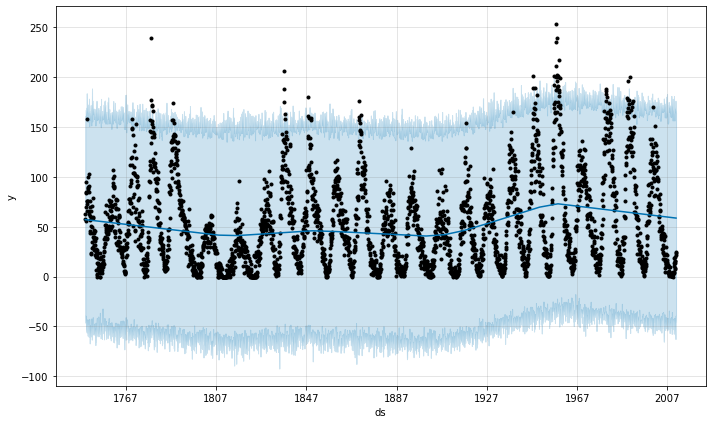

In [64]:

def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.8):
    m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
                seasonality_mode = 'multiplicative', 
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    m = m.fit(dataframe)
    
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    print('Displaying Prophet plot')
    fig1 = m.plot(forecast)
    return forecast
    
pred = fit_predict_model(clean_df)


# Detecting Anomalies:
* The light blue boundaries in the above graph are yhat_upper and yhat_lower.
* If y value is greater than yhat_upper and less than yhat lower then it is an anomaly.
* Also getting the importance of that anomaly based on its distance from yhat_upper and yhat_lower.

In [65]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

pred = detect_anomalies(pred)

In [66]:
pred.head()

,ds,trend,yhat,yhat_lower,yhat_upper,fact,anomaly,importance
0,1749-01-01,57.205089,57.205089,-45.365861,161.246320,58.0,0,0.0
1,1749-02-01,57.182610,57.182610,-39.043712,158.294246,62.6,0,0.0
2,1749-03-01,57.162307,57.162307,-46.358373,161.915886,70.0,0,0.0
3,1749-04-01,57.139828,57.139828,-43.321394,167.399336,55.7,0,0.0
4,1749-05-01,57.118075,57.118075,-49.662956,161.813923,85.0,0,0.0


# Plotting the anomalies for a better view

In [67]:

def plot_anomalies(forecasted):

    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
    
    x=alt.X('ds:T',  title ='date'),
    
    y='yhat_upper',
    
    y2='yhat_lower',
    
    tooltip=['yearmonthdate(ds)', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive().properties(
        title='Anomaly Detection'
    )

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='Sunspots'),    
        tooltip=['yearmonthdate(ds)', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()

    
    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='Sunspots'),    
        tooltip=['yearmonthdate(ds)', 'fact', 'yhat_lower', 'yhat_upper'],
        size = alt.Size( 'importance', legend=None)
    ).interactive()

    return alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20)
              
plot_anomalies(pred)


alt.LayerChart(...)

References:
* http://www-personal.umich.edu/~mejn/cp/programs.html
* https://towardsdatascience.com/anomaly-detection-time-series-4c661f6f165f
* https://github.com/altair-viz/altair/issues/1270


---


<br><br><br>

<br><br><br>

---


In [69]:
# libraries
import os

import dask 
import dask.dataframe as dd
from dask.distributed import Client, progress

import pandas as pd 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

In [70]:

%cd D:\GITHUB_Repos\SensorAnalysis\ENTER\data   


D:\GITHUB_Repos\SensorAnalysis\ENTER\data


In [71]:
! dir

 Volume in drive D is New Volume
 Volume Serial Number is A060-E317

 Directory of D:\GITHUB_Repos\SensorAnalysis\ENTER\data

09/16/2021  11:34 AM    <DIR>          .
09/16/2021  11:34 AM    <DIR>          ..
09/16/2021  11:49 AM       109,633,063 anomaly_detection_isolation_forest_smalldataset.html
09/16/2021  11:23 AM       109,633,048 inital_analysis_anomaly_detection.html
09/15/2021  01:37 PM        96,949,370 prelim_file_UML.csv
               3 File(s)    316,215,481 bytes
               2 Dir(s)  918,268,452,864 bytes free


In [72]:

# %cd D:\CRITICAL_MAIN_DATAFILE__MILESTONE_II\AoT_Chicago.complete.2021-09-12

df = pd.read_csv( 'prelim_file_UML.csv', 
                  index_col  = ['timestamp'] )


In [96]:

df.head(10)


,value,timestamp
timestamp,,
2018-05-01 00:00:18,30.2,2018-05-01 00:00:18
2018-05-01 00:00:44,30.3,2018-05-01 00:00:44
2018-05-01 00:01:10,30.4,2018-05-01 00:01:10
2018-05-01 00:01:35,30.3,2018-05-01 00:01:35
2018-05-01 00:02:01,30.4,2018-05-01 00:02:01
2018-05-01 00:02:27,30.3,2018-05-01 00:02:27
2018-05-01 00:02:52,30.3,2018-05-01 00:02:52
2018-05-01 00:03:18,30.2,2018-05-01 00:03:18
2018-05-01 00:03:44,30.2,2018-05-01 00:03:44


In [98]:

# df.drop('sensor', axis=1, inplace=True)


In [99]:

df.columns = ['value', 'timestamp']


In [100]:
df.head(10)

,value,timestamp
timestamp,,
2018-05-01 00:00:18,30.2,2018-05-01 00:00:18
2018-05-01 00:00:44,30.3,2018-05-01 00:00:44
2018-05-01 00:01:10,30.4,2018-05-01 00:01:10
2018-05-01 00:01:35,30.3,2018-05-01 00:01:35
2018-05-01 00:02:01,30.4,2018-05-01 00:02:01
2018-05-01 00:02:27,30.3,2018-05-01 00:02:27
2018-05-01 00:02:52,30.3,2018-05-01 00:02:52
2018-05-01 00:03:18,30.2,2018-05-01 00:03:18
2018-05-01 00:03:44,30.2,2018-05-01 00:03:44


In [85]:

# alt.Chart(df).mark_line(size=3, opacity=0.8, color = 'Orange').encode(
#         x='yearmonthdate(timestamp):T',
#         y=alt.Y('value:Q', title='Values'),    
#         tooltip=['yearmonthdate(timestamp)', 'Values']
#     ).interactive().properties(width=900, height=450,title='Sunspots based on Months')\
#               .configure_title(fontSize=20)


In [82]:
df.columns

Index(['value', 'timestamp'], dtype='object')

In [88]:
df.head(3)

,value,timestamp
timestamp,,
2018-05-01 00:00:18,30.2,2018-05-01 00:00:18
2018-05-01 00:00:44,30.3,2018-05-01 00:00:44
2018-05-01 00:01:10,30.4,2018-05-01 00:01:10


In [78]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [95]:

# zebra = alt.Chart(df).mark_line(size=1, 
#                         opacity=0.7, 
#                         color = 'green').encode(
#                            x='timestamp:T',
#                            y=alt.Y('value:Q', title='Values'),    
#                         tooltip=['timestamp', 'value']
#     ).interactive().properties(width=900, 
#                                height=450,
#                                title='1yr+ Temperature - Sensor1')\
#               .configure_title(fontSize=10)

# zebra


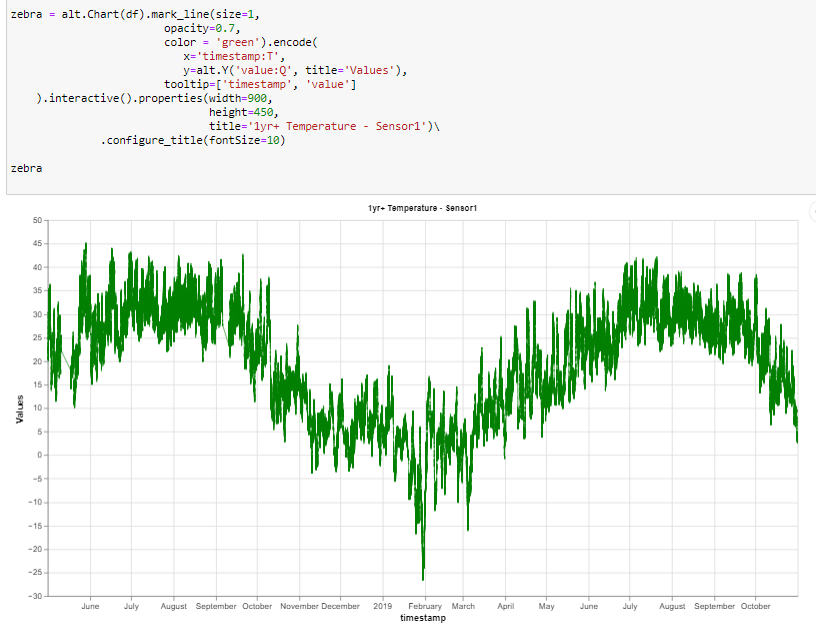

In [93]:
# zebra.save('D:\\altair_plot_million_pts_anomalies.html')

In [104]:

minidf = df[:50000].copy()


In [105]:
len(minidf)

50000

In [110]:
# alt.renderers.enable('svg')

# should i do this ? 

In [111]:

alt.Chart(minidf).mark_rect().encode(
    alt.X('hours(timestamp):O', title='hour of day'),
    alt.Y('monthdate(timestamp):O', title='date'),
    alt.Color('value:Q', title='temperature (C)')
)


ValueError: Saving charts in 'svg' format requires the altair_saver package: see http://github.com/altair-viz/altair_saver/

alt.Chart(...)

In [102]:
# this works !!!!!!!!!!!!!!

# alt.Chart(df).mark_rect().encode(
#     alt.X('hoursminutes(timestamp):O', title='hour of day'),
#     alt.Y('monthdate(timestamp):O', title='date'),
#     alt.Color('value:Q', title='temperature (C)')
# )